# GBRAS-Net

## Libraries

In [1]:
from scipy import misc, ndimage, signal
from sklearn.model_selection  import train_test_split
import numpy
import numpy as np
import random
import ntpath
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from keras import optimizers 
from keras import regularizers
import tensorflow as tf
import cv2
from keras import backend as K
from time import time
import time as tm
import datetime
from operator import itemgetter
import glob
from skimage.util.shape import view_as_blocks
from keras.utils import np_utils
from keras.utils import to_categorical

## GPU

In [2]:
!nvidia-smi
#!kill PIDnumber

Sat Nov  7 16:35:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 450.57       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:0A:00.0  On |                  N/A |
|ERR!   29C    P5   ERR! / 250W |    284MiB / 11016MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 30 SRM filters for preprocessing and the activation function

In [3]:
################################################## 30 SRM FILTERS
srm_weights = np.load('SRM_Kernels1.npy') 
biasSRM=numpy.ones(30)
print (srm_weights.shape)
################################################## TLU ACTIVATION FUNCTION
T3 = 3;
def Tanh3(x):
    tanh3 = K.tanh(x)*T3
    return tanh3
##################################################

(5, 5, 1, 30)


## GBRAS-Net architecture

In [4]:
def GBRAS_Net():
    tf.keras.backend.clear_session()
    #Inputs
    inputs = tf.keras.Input(shape=(256,256,1), name="input_1")
    #Layer 1
    layers = tf.keras.layers.Conv2D(30, (5,5), weights=[srm_weights,biasSRM], strides=(1,1), padding='same', trainable=False, activation=Tanh3, use_bias=True)(inputs)
    layers1 = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 2
    layers = tf.keras.layers.DepthwiseConv2D(1)(layers1)
    layers = tf.keras.layers.SeparableConv2D(30,(3,3), padding='same', activation="elu",depth_multiplier=3)(layers) 
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 3
    layers = tf.keras.layers.DepthwiseConv2D(1)(layers)
    layers = tf.keras.layers.SeparableConv2D(30,(3,3), padding='same', activation="elu",depth_multiplier=3)(layers) 
    layers2 = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    skip1 =   tf.keras.layers.Add()([layers1, layers2])
    #Layer 4
    layers = tf.keras.layers.Conv2D(30, (3,3), strides=(1,1), activation="elu", padding='same', kernel_initializer='glorot_uniform')(skip1) 
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 5
    layers = tf.keras.layers.Conv2D(30, (3,3), strides=(1,1), activation="elu", padding='same', kernel_initializer='glorot_uniform')(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 6
    layers = tf.keras.layers.AveragePooling2D((2,2), strides= (2,2))(layers)
    #Layer 7
    layers = tf.keras.layers.Conv2D(60, (3,3), strides=(1,1), activation="elu", padding='same', kernel_initializer='glorot_uniform')(layers) 
    layers3 = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 8
    layers = tf.keras.layers.DepthwiseConv2D(1)(layers3)
    layers = tf.keras.layers.SeparableConv2D(60,(3,3), padding='same', activation="elu",depth_multiplier=3)(layers) 
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 9
    layers = tf.keras.layers.DepthwiseConv2D(1)(layers)
    layers = tf.keras.layers.SeparableConv2D(60,(3,3), padding='same', activation="elu",depth_multiplier=3)(layers) 
    layers4 = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    skip2 =   tf.keras.layers.Add()([layers3, layers4])
    #Layer 10
    layers = tf.keras.layers.Conv2D(60, (3,3), strides=(1,1), activation="elu", padding='same', kernel_initializer='glorot_uniform')(skip2) 
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 11
    layers = tf.keras.layers.AveragePooling2D((2,2), strides= (2,2))(layers)
    #Layer 12
    layers = tf.keras.layers.Conv2D(60, (3,3), strides=(1,1), activation="elu", padding='same', kernel_initializer='glorot_uniform')(layers) 
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 13
    layers = tf.keras.layers.AveragePooling2D((2,2), strides= (2,2))(layers)
    #Layer 14
    layers = tf.keras.layers.Conv2D(60, (3,3), strides=(1,1), activation="elu", padding='same', kernel_initializer='glorot_uniform')(layers) 
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 15
    layers = tf.keras.layers.AveragePooling2D((2,2), strides= (2,2))(layers)
    #Layer 16
    layers = tf.keras.layers.Conv2D(30, (1,1), strides=(1,1), activation="elu", padding='same', kernel_initializer='glorot_uniform')(layers) 
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 17
    layers = tf.keras.layers.Conv2D(2, (1,1), strides=(1,1), activation="elu", padding='same', kernel_initializer='glorot_uniform')(layers) 
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 18
    layers = tf.keras.layers.GlobalAveragePooling2D(data_format="channels_last")(layers)
    #Layer 19
    predictions = tf.keras.layers.Softmax(axis=1)(layers)
    #Model generation
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    #Optimizer
    optimizer=tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    print ("Model GBRAS-Net Generated")
    #Model compilation
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


## Paths to save trained models epoch by epoch and final accuracy and loss curves

In [5]:
path_log_base = './logs'
path_img_base = './images'
if not os.path.exists(path_log_base):
    os.makedirs(path_log_base)
if not os.path.exists(path_img_base):
    os.makedirs(path_img_base)

## Defining different functions to work with the architecture

In [6]:
def train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size, epochs, model_name=""):
    start_time = tm.time()
    log_dir=path_log_base+"/"+model_name+"_"+str(datetime.datetime.now().isoformat()[:19].replace("T", "_").replace(":","-"))
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)
    filepath = log_dir+"/saved-model-{epoch:03d}-{val_accuracy:.4f}.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=False, mode='max')
    model.reset_states()
    
    global lossTEST
    global accuracyTEST
    global lossTRAIN
    global accuracyTRAIN
    global lossVALID
    global accuracyVALID
    lossTEST,accuracyTEST   = model.evaluate(X_test, y_test,verbose=None)
    lossTRAIN,accuracyTRAIN = model.evaluate(X_train, y_train,verbose=None)
    lossVALID,accuracyVALID = model.evaluate(X_valid, y_valid,verbose=None)

    global history
    global model_Name
    global log_Dir
    model_Name = model_name
    log_Dir = log_dir
    print("Starting the training...")
    history=model.fit(X_train, y_train, epochs=epochs, 
                      callbacks=[tensorboard,checkpoint], 
                      batch_size=batch_size,validation_data=(X_valid, y_valid),verbose=2)
    
    metrics = model.evaluate(X_test, y_test, verbose=0)
     
    TIME = tm.time() - start_time
    print("Time "+model_name+" = %s [seconds]" % TIME)
    
    print("\n")
    print(log_dir)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [7]:
def Final_Results_Test(PATH_trained_models):
    global AccTest
    global LossTest
    AccTest = []
    LossTest= [] 
    B_accuracy = 0 #B --> Best
    for filename in sorted(os.listdir(PATH_trained_models)):
        if filename != ('train') and filename != ('validation'):
            print(filename)
            model = tf.keras.models.load_model(PATH_trained_models+'/'+filename, custom_objects={'Tanh3':Tanh3})
            loss,accuracy = model.evaluate(X_test, y_test,verbose=0)
            print(f'Loss={loss:.4f} y Accuracy={accuracy:0.4f}'+'\n')
            BandAccTest  = accuracy
            BandLossTest = loss
            AccTest.append(BandAccTest)    
            LossTest.append(BandLossTest)  
            
            if accuracy > B_accuracy:
                B_accuracy = accuracy
                B_loss = loss
                B_name = filename
    
    print("\n\nBest")
    print(B_name)
    print(f'Loss={B_loss:.4f} y Accuracy={B_accuracy:0.4f}'+'\n')

In [8]:
def graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID):
    numbers=AccTest
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% total epochs
        index, value = numbers_sort[i]
        print("Test Accuracy {}, epoch:{}\n".format(value, index+1))
    
    print("")
    
    numbers=history.history['accuracy']
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% total epochs
        index, value = numbers_sort[i]
        print("Train Accuracy {}, epoch:{}\n".format(value, index+1))
    
    print("")
    
    numbers=history.history['val_accuracy']
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% total epochs
        index, value = numbers_sort[i]
        print("Validation Accuracy {}, epoch:{}\n".format(value, index+1))

    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(10, 10))
        plt.plot(np.concatenate([np.array([accuracyTRAIN]),np.array(history.history['accuracy'])],axis=0))
        plt.plot(np.concatenate([np.array([accuracyVALID]),np.array(history.history['val_accuracy'])],axis=0))
        plt.plot(np.concatenate([np.array([accuracyTEST]),np.array(AccTest)],axis=0)) #Test
        plt.title('Accuracy Vs Epoch')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
        plt.grid('on')
        plt.savefig(path_img_base+'/Accuracy_GBRAS_Net_'+model_Name+'.eps', format='eps')
        plt.savefig(path_img_base+'/Accuracy_GBRAS_Net_'+model_Name+'.svg', format='svg')
        plt.savefig(path_img_base+'/Accuracy_GBRAS_Net_'+model_Name+'.pdf', format='pdf')     
        plt.show()
        
        plt.figure(figsize=(10, 10))
        plt.plot(np.concatenate([np.array([lossTRAIN]),np.array(history.history['loss'])],axis=0))
        plt.plot(np.concatenate([np.array([lossVALID]),np.array(history.history['val_loss'])],axis=0))
        plt.plot(np.concatenate([np.array([lossTEST]),np.array(LossTest)],axis=0)) #Test
        plt.title('Loss Vs Epoch')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
        plt.grid('on')
        plt.savefig(path_img_base+'/Loss_GBRAS_Net_'+model_Name+'.eps', format='eps')
        plt.savefig(path_img_base+'/Loss_GBRAS_Net_'+model_Name+'.svg', format='svg')
        plt.savefig(path_img_base+'/Loss_GBRAS_Net_'+model_Name+'.pdf', format='pdf') 
        plt.show() 

# Working with BOSSbase 1.01

## Loading BOSSbase 1.01 dataset for S-UNIWARD 0.4bpp

In [9]:
n=256
def load_images(path_pattern):
    files=glob.glob(path_pattern)
    X=[]
    for f in sorted(files):
        I = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        patches = view_as_blocks(I, (n, n))
        for i in range(patches.shape[0]):
            for j in range(patches.shape[1]):
                X.append( [ patches[i,j] ] )
    X=numpy.array(X)
    return X

pathc = './DATABASES/BOSSbase-1.01'
paths = './DATABASES/BOSSbase-1.01/S-UNIWARD/0.4bpp'

Xc_ = load_images(pathc+'/cover/*.pgm') ##COVER IMAGES
Xs_ = load_images(paths+'/stego/*.pgm') ##STEGO IMAGES
X_  = (numpy.vstack((Xc_, Xs_)))
Xt_ = (numpy.hstack(([0]*len(Xc_), [1]*len(Xs_))))
Xt_ = np_utils.to_categorical(Xt_, 2)
X_  = np.rollaxis(X_,1,4)  #channel axis shifted to last axis

print("Total image data and labels",X_.shape,Xt_.shape)
#Cover hasta las 10000 ##Train hasta las 4000 ##Valid hasta de las 4000 a las 5000 ##Test de las 5000 a las 10000
X_train = np.concatenate([X_[0:4000],X_[10000:14000]],axis=0)
X_valid = np.concatenate([X_[4000:5000],X_[14000:15000]],axis=0)
X_test  = np.concatenate([X_[5000:10000],X_[15000:20000]],axis=0)
y_train = np.concatenate([Xt_[0:4000],Xt_[10000:14000]],axis=0)
y_valid = np.concatenate([Xt_[4000:5000],Xt_[14000:15000]],axis=0)
y_test  = np.concatenate([Xt_[5000:10000],Xt_[15000:20000]],axis=0)
#Controled randomized data for training
X_dat0, X_dat1, y_dat0, y_dat1 = train_test_split(X_train, y_train, test_size=0.50, random_state=64) 
X_train = np.concatenate([X_dat0,X_dat1],axis=0) 
y_train = np.concatenate([y_dat0,y_dat1],axis=0) 
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

Total image data and labels (20000, 256, 256, 1) (20000, 2)
(8000, 256, 256, 1)
(8000, 2)
(2000, 256, 256, 1)
(2000, 2)
(10000, 256, 256, 1)
(10000, 2)


## Load GBRAS-Net architecture, and show the layers

In [10]:
model = GBRAS_Net()
model.summary()

Model GBRAS-Net Generated
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 30) 780         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 30) 90          conv2d[0][0]                     
__________________________________________________________________________________________________
depthwise_conv2d (DepthwiseConv (None, 256, 256, 30) 60          batch_normalization[0][0]        
____________________________________________________________________

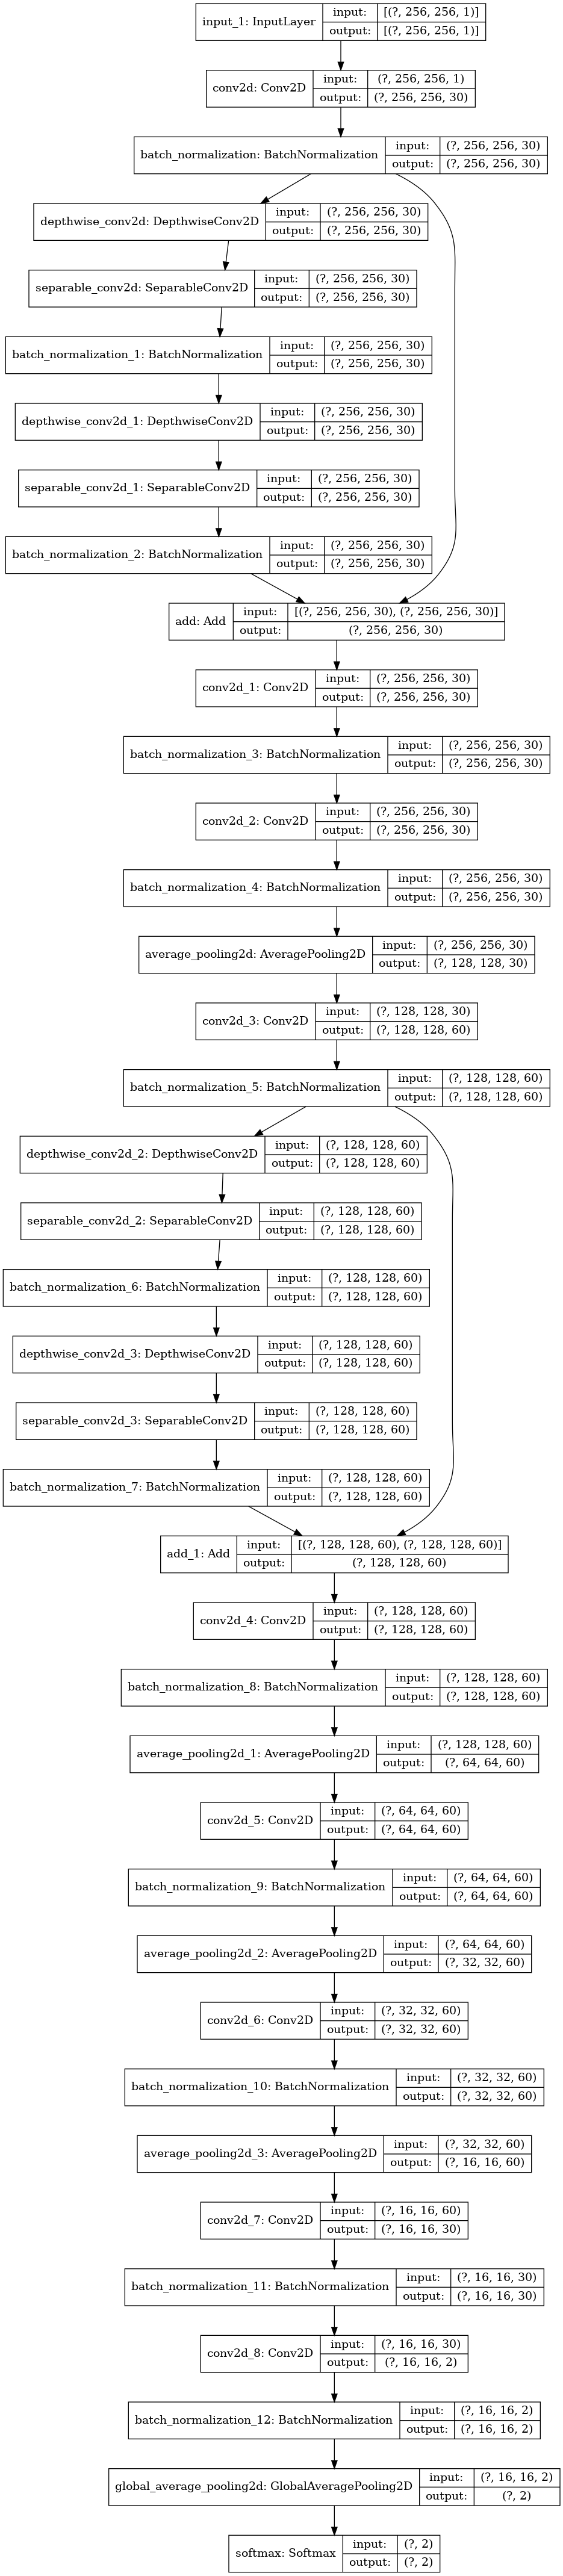

In [11]:
#tf.keras.utils.plot_model(model, show_shapes=True) 

## Train the GBRAS-Net architecture

In [ ]:
train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=32, epochs=100, model_name="model_GBRAS-Net_S_UNIWARD_04bpp") 


## Show the performance on Test data

In [ ]:
Final_Results_Test(log_Dir) 

## Shows the best 5% of all trained and saved models in the test data set and shows accuracy and loss curves

In [ ]:
# GRAPHICS OF THE THREE (TRAIN, TEST AND VALIDATION) CURVES
graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID)


In [ ]:
print(log_Dir)

# NOTE for 0.2bpp experiments

### To work with 0.2bpp, load a model where CNN has already converged to a certain extent. (in about 25 epochs of a model trained with 0.4bpp or a model with 60% accuracy). You can see the behavior and accuracy that the architecture reaches with the steganographic algorithm 0.2bpp.

path_log = 'PATH' #put the path where the models have been saved in the training process
model_name = '/NAME.hdf5' #put the name of the selected model with an 60% accuracy for example
model = tf.keras.models.load_model(path_log+model_name, custom_objects={'Tanh3':Tanh3}, compile=True)
loss,accuracy = model.evaluate(X_test,y_test,verbose=0)
print(f'Loss={loss:.4f} and Accuracy={accuracy:0.4f}') 


# Working with BOSSbase 1.01 + BOWS2

### In the paper experiments, we took BOSSbase 1.01 and BOWS2 only with 0.2bpp.

## 1) Load the best model obtained with BOSSbase 1.01

path_log = 'PATH' #put the path where the models have been saved in the training process
model_name = '/NAME_OF_THE_BEST_MODEL.hdf5' #put the name of the BEST MODEL FOR BOSSBASE 1.01
model = tf.keras.models.load_model(path_log+model_name, custom_objects={'Tanh3':Tanh3}, compile=True)
loss,accuracy = model.evaluate(X_test,y_test,verbose=0) #Test BOSSbase 1.01
print(f'Loss={loss:.4f} and Accuracy={accuracy:0.4f}') 


## 2) Load the BOWS2 dataset

n=256
def load_images(path_pattern):
    files=glob.glob(path_pattern)
    X=[]
    for f in sorted(files):
        I = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        patches = view_as_blocks(I, (n, n))
        for i in range(patches.shape[0]):
            for j in range(patches.shape[1]):
                X.append( [ patches[i,j] ] )
    X=numpy.array(X)
    return X

pathc = './DATABASES/BOWS2'
paths = './DATABASES/BOWS2/S-UNIWARD/0.2bpp'

Xc_ = load_images(pathc+'/cover/*.pgm') ##COVER IMAGES
Xs_ = load_images(paths+'/stego/*.pgm') ##STEGO IMAGES
X_  = (numpy.vstack((Xc_, Xs_)))
X_  = np.rollaxis(X_,1,4) 
Xt_ = (numpy.hstack(([0]*len(Xc_), [1]*len(Xs_))))
Xt_ = np_utils.to_categorical(Xt_, 2)

print(X_.shape) # 10000 image pairs from BOWS2
print(Xt_.shape)

print(X_train.shape) # 4000 image pairs from BOSSbase 1.01
print(y_train.shape)

X_train = np.concatenate([X_train,X_],axis=0) #Controled randomized data for training, joining 4000 image pairs from BOSSbase 1.01 and 10000 image pairs from BOWS2
y_train = np.concatenate([y_train,Xt_],axis=0)

X_dat0, X_dat1, y_dat0, y_dat1 = train_test_split(X_train, y_train, test_size=0.50, random_state=64) 
X_train = np.concatenate([X_dat0,X_dat1],axis=0) 
y_train = np.concatenate([y_dat0,y_dat1],axis=0) 

print(X_train.shape) #14000 image pairs, 4000 from BOSSbase 1.01 and 10000 from BOWS2
print(y_train.shape)

## 3) Train the architecture BOSSbase 1.01 and BOWS2

train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=32, epochs=100, model_name="model_GBRAS-Net_S_UNIWARD_04bpp_BOSSbase_1.01_and_BOWS2")


## 4) Show the performance on Test data

Final_Results_Test(log_Dir) 

## 5) Shows the best 5% of all trained and saved models in the test data set and shows accuracy and loss curves. (TRAIN, TEST AND VALIDATION CURVES)

graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID)
